# Notebook for evaluating trained CNNs
- Load trained LCU
- Select folder with eval data (idea is that test = patched and predict = not patched). So incorporate both ways.
- Create DL with same label mappings as original. 
- Predict those, figure out way to show images of memory-mapped images (ie predict set)
- Or just stick with test set up for now? 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys
import pickle
sys.path.append('scripts/')
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import rasterio, rasterio.plot
import shapely as shp
import xarray as xr
import rioxarray as rxr
from tqdm import tqdm
import pandas as pd
import geopandas as gpd
import loadpaths
import land_cover_analysis as lca
import land_cover_visualisation as lcv
import land_cover_models as lcm
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torch 
import pytorch_lightning as pl
# import segmentation_models_pytorch as smp

path_dict = loadpaths.loadpaths()

## Use trained CNN to make predictions of unseen data:

In [5]:
# LCU = lcm.load_model(filename='scripts/LCU_2022-11-28-2039.data', verbose=0)
# LCU = lcm.load_model(filename='scripts/LCU_2022-11-30-1205.data')
LCU = lcm.load_model(filename='scripts/LCU_2022-12-14-1935.data')
LCU.eval()
# ## From https://pytorch-lightning.readthedocs.io/en/stable/common/checkpointing_basic.html#save-a-checkpoint

# ## LightningModule from checkpoint
# ## To load a LightningModule along with its weights and hyperparameters use the following method:

# model = LCU.load_from_checkpoint("/path/to/checkpoint.ckpt")


Loaded LCU_2022-12-14-1935
loss_function is focal_loss
n_max_epochs is 15
LandCoverUNet class using FocalClass2
13 training tiles CDE + urban.


Instance LCU_2022-12-14-1935 of LandCoverUNet class

In [4]:
## Patches of eval data set:
dir_im_patches = '/home/tplas/data/gis/most recent APGB 12.5cm aerial/evaluation_tiles/images'
dir_mask_patches = '/home/tplas/data/gis/most recent APGB 12.5cm aerial/evaluation_tiles/masks_80s/'
dir_mask_patches_2 = '/home/tplas/data/gis/most recent APGB 12.5cm aerial/evaluation_tiles/masks_2022/'
path_mapping_dict = '/home/tplas/repos/cnn-land-cover/content/label_mapping_dicts/label_mapping_dict__main_categories__2022-11-17-1512.pkl'

assert LCU.dict_training_details['n_classes'] == 7

# Create DS with just 1 set of masks:
# test_ds = lcm.DataSetPatches(im_dir=dir_im_patches, mask_dir=dir_mask_patches_2, 
#                             # mask_suffix='_lc_80s_mask.npy',
#                             mask_suffix='_lc_2022_mask.npy',
#                             preprocessing_func=LCU.preprocessing_func, path_mapping_dict=path_mapping_dict,
#                             shuffle_order_patches=True, relabel_masks=False,
#                             subsample_patches=True, frac_subsample=.2)

## Create DS with 2 sets of masks:
test_ds = lcm.DataSetPatchesTwoMasks(im_dir=dir_im_patches, mask_dir=dir_mask_patches, 
                            mask_suffix='_lc_80s_mask.npy',
                            mask_dir_2=dir_mask_patches_2,
                            mask_suffix_2='_lc_2022_mask.npy',
                            preprocessing_func=LCU.preprocessing_func, path_mapping_dict=path_mapping_dict,
                            shuffle_order_patches=True, relabel_masks=True,
                            subsample_patches=False, frac_subsample=1)

assert test_ds.n_classes == LCU.dict_training_details['n_classes']
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=20, num_workers=16)

Patches ordered randomly
Loaded 11250 patches
Loaded label_mapping_dict__main_categories__2022-11-17-1512.pkl to map labels
Relabelling mask 1: True
Relabelling mask 2: False


In [14]:
test_ds.df_patches.iloc[500]

patch_name                                           SK0686_patch221
im_filepath        /home/tplas/data/gis/most recent APGB 12.5cm a...
mask_filepath      /home/tplas/data/gis/most recent APGB 12.5cm a...
mask_2_filepath    /home/tplas/data/gis/most recent APGB 12.5cm a...
Name: 500, dtype: object

(3, 512, 512) <class 'numpy.ndarray'>
(3, 512, 512) <class 'numpy.ndarray'>
(3, 512, 512) <class 'numpy.ndarray'>
(3, 512, 512) <class 'numpy.ndarray'>


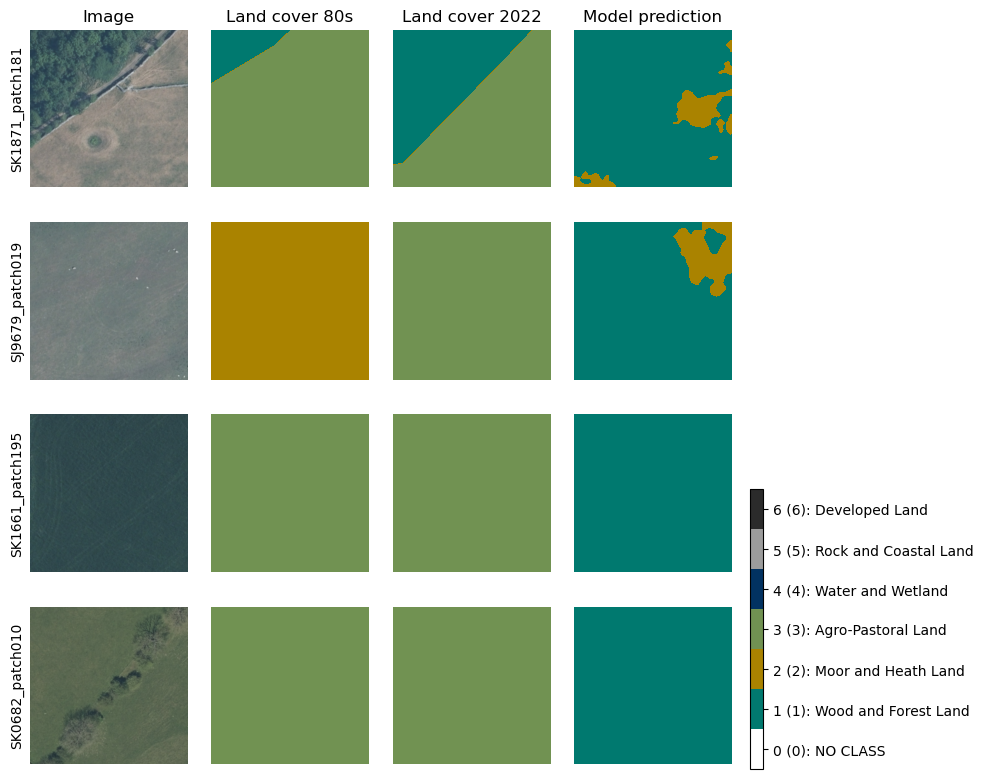

In [13]:
kk += 4

# kk = 0 
tmp_batch, names_patches = lcm.get_batch_from_ds(ds=test_ds, batch_size=4, start_ind=kk)
_ = lcm.predict_single_batch_from_testdl_or_batch(model=LCU, batch=tmp_batch,
                                        #  test_dl=test_dl, 
                                         preprocessing_fun=test_ds.preprocessing_func,
                                         lc_class_name_list=test_ds.class_name_list, 
                                         unique_labels_array=test_ds.unique_labels_arr,
                                         names_patches=names_patches)

In [11]:
trainer = pl.Trainer(max_epochs=10, accelerator='gpu', devices=1)  # run on GPU; and set max_epochs.

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [88]:
LCU.test_confusion_mat.sum() / 64e6

46.08

In [50]:
LCU.skip_factor_eval = 4

In [51]:
trainer.test(LCU, dataloaders=test_dl)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_ce_loss          1.3150688409805298
     test_focal_loss        1.0253939628601074
      test_iou_loss         0.9579325914382935
        test_loss           1.0253939628601074
  test_overall_accuracy     0.8515828671373136
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 1.0253939628601074,
  'test_ce_loss': 1.3150688409805298,
  'test_focal_loss': 1.0253939628601074,
  'test_iou_loss': 0.9579325914382935,
  'test_overall_accuracy': 0.8515828671373136}]

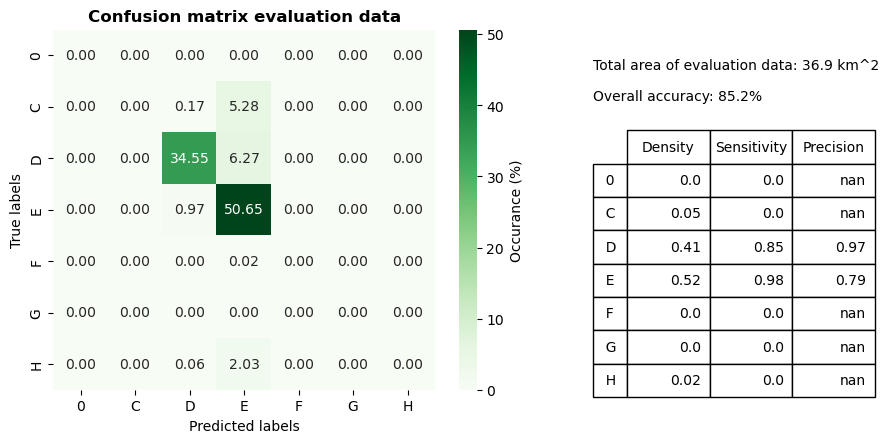

In [9]:
_ = lcv.plot_confusion_summary(LCU, normalise_hm=True)

## Predict full tiles:

In [3]:
tile_path = '/home/tplas/data/gis/most recent APGB 12.5cm aerial/evaluation_tiles/117574_20221122/12.5cm Aerial Photo/117574-1_RGB_1_Shape/SK0366.tif'

In [6]:
mask_tile, mask_shp = lcm.prediction_one_tile(model=LCU, tilepath=tile_path, 
                                              create_shp=True, save_shp=False, model_name='LCU_2022-11-30-1205')

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Divided tile
Predicting patches:


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/tplas/anaconda3/envs/geo/lib/python3.7/site-packages/segmentation_models_pytorch/base/modules.py:116: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.activation(x)


Now creating polygons of prediction


/home/tplas/anaconda3/envs/geo/lib/python3.7/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [7]:
mask_shp = gpd.read_file('/home/tplas/tmp_filter_pred/original_predictions_SK0366/original_predictions_SK0366.shp')

In [177]:
tmp = lca.filter_small_polygons_from_gdf(gdf=mask_shp, area_threshold=1000)

Current iteration: 0/5
Number of pols smaller than 1000: 6780/6823


6780it [02:32, 44.33it/s] 


Number of new polygons: 354, number of old polygons: 6823
Current iteration: 1/5


324it [00:02, 109.97it/s]


Number of new polygons: 36, number of old polygons: 354
Current iteration: 2/5


6it [00:00, 128.37it/s]


Number of new polygons: 36, number of old polygons: 36
No more changes. Trying to sort other way around.
Current iteration: 3/5


6it [00:00, 10.76it/s]


Number of new polygons: 30, number of old polygons: 36
No more polygons smaller than 1000. Stopping.


In [167]:
tmp.to_file('/home/tplas/tmp_filter_pred/dissolved_36_left')

/home/tplas/anaconda3/envs/geo/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  """Entry point for launching an IPython kernel.


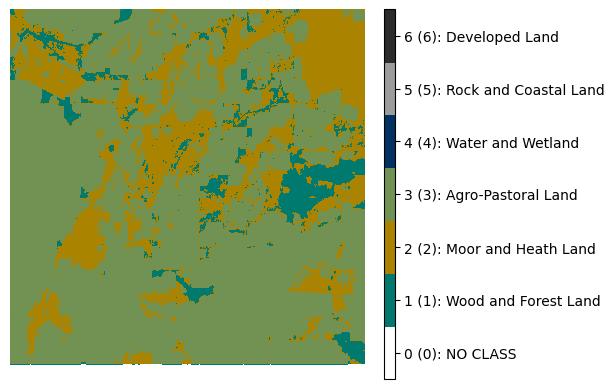

In [120]:
lcv.plot_landcover_image(mask_tile, lc_class_name_list=test_ds.class_name_list, 
                                    unique_labels_array=test_ds.unique_labels_arr)

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


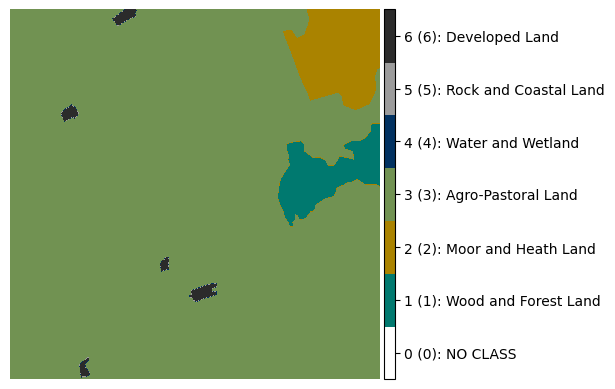

In [7]:
tile_path_mask = '/home/tplas/data/gis/most recent APGB 12.5cm aerial/evaluation_tiles/117574_20221122/tile_masks_2022/SK0366_lc_2022_mask.tif'
mask_tile_true = lca.load_tiff(tile_path_mask)

lcv.plot_landcover_image(np.squeeze(mask_tile_true), lc_class_name_list=test_ds.class_name_list, 
                                         unique_labels_array=test_ds.unique_labels_arr)

scripts/land_cover_visualisation.py:596: RuntimeWarning: invalid value encountered in double_scalars
  sens_arr[i_c] = conf_mat[i_c, i_c] / conf_mat[i_c, :].sum()  # sum of true pos + false neg
scripts/land_cover_visualisation.py:597: RuntimeWarning: invalid value encountered in double_scalars
  prec_arr[i_c] = conf_mat[i_c, i_c] / conf_mat[:, i_c].sum()  # sum of true pos + false pos


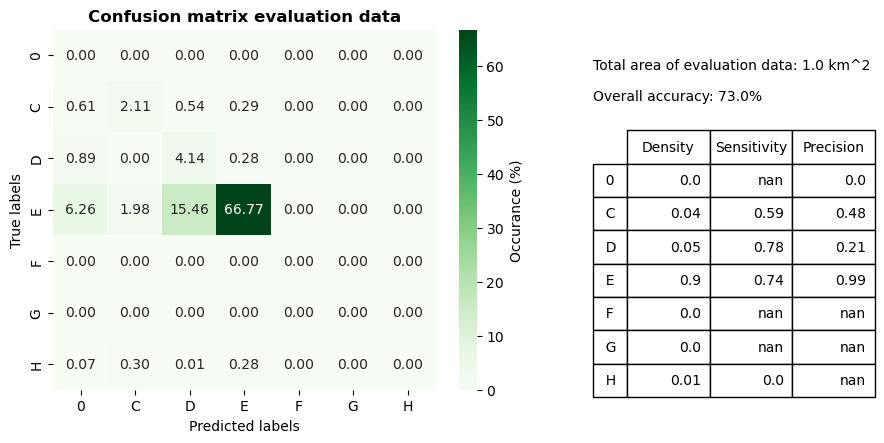

In [28]:
conf_mat = lca.compute_confusion_mat_from_two_masks(mask_true=mask_tile_true, mask_pred=mask_tile, 
                                                    lc_class_name_list=test_ds.class_name_list, 
                                                    unique_labels_array=test_ds.unique_labels_arr)
_ = lcv.plot_confusion_summary(conf_mat=conf_mat, class_name_list=test_ds.class_name_list, normalise_hm=True)

In [63]:
import logging
# pl.utilities.distributed.log.setLevel(logging.ERROR)

logging.getLogger("pytorch_lightning").setLevel(logging.ERROR)
dict_acc_tiles, dict_df_stats_tiles, dict_conf_mat = lcm.tile_prediction_wrapper(model=LCU, save_shp=False,
                            dir_im='/home/tplas/data/gis/most recent APGB 12.5cm aerial/evaluation_tiles/117574_20221122/12.5cm Aerial Photo/',
                            dir_mask_eval='/home/tplas/data/gis/most recent APGB 12.5cm aerial/evaluation_tiles/117574_20221122/tile_masks_2022/')

Loaded 50 tiffs from /home/tplas/data/gis/most recent APGB 12.5cm aerial/evaluation_tiles/117574_20221122/12.5cm Aerial Photo/ subdirs
Evaluating vs true masks


0it [00:00, ?it/s]/home/tplas/anaconda3/envs/geo/lib/python3.7/site-packages/segmentation_models_pytorch/base/modules.py:116: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.activation(x)
1it [00:18, 18.14s/it]/home/tplas/anaconda3/envs/geo/lib/python3.7/site-packages/segmentation_models_pytorch/base/modules.py:116: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.activation(x)
2it [00:36, 18.19s/it]/home/tplas/anaconda3/envs/geo/lib/python3.7/site-packages/segmentation_models_pytorch/base/modules.py:116: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.activation(x)
3it [00:55, 18.44s/it]/home/tplas/anaconda3/envs/geo/lib/python3.7/site-packages/segmentation_models_pytorch/base/modules.py:116: UserWarning: Implicit dimension choic

KeyboardInterrupt: 

In [55]:
dict_acc_tiles

{'SK0554': 0.679213625,
 'SK1798': 0.921134078125,
 'SK0686': 0.751133984375,
 'SK2196': 0.921348171875,
 'SK1566': 0.74488196875,
 'SK1399': 0.913769796875,
 'SK1357': 0.596548890625,
 'SK1661': 0.884349546875,
 'SK0896': 0.921592921875,
 'SK0685': 0.835724171875,
 'SE1203': 0.915704828125,
 'SK2777': 0.013827125,
 'SJ9679': 0.84272253125,
 'SK0684': 0.710419390625,
 'SK1998': 0.91987184375,
 'SK0879': 0.78577859375,
 'SK1472': 0.861179125,
 'SK2096': 0.921551453125,
 'SK1360': 0.8071076875,
 'SK1464': 0.867394859375,
 'SE0503': 0.9216,
 'SK1683': 0.712756578125,
 'SK0366': 0.730219171875,
 'SK2496': 0.795417453125,
 'SK0961': 0.873721234375,
 'SK2091': 0.921566015625,
 'SK0464': 0.79568721875,
 'SK0852': 0.79330040625,
 'SJ9566': 0.83712484375,
 'SK2074': 0.656678359375,
 'SK1975': 0.858490875,
 'SK1874': 0.818774421875,
 'SE1400': 0.901390578125,
 'SK0752': 0.75744090625,
 'SK0988': 0.921552609375,
 'SK2055': 0.369127359375,
 'SJ9772': 0.86649284375,
 'SK1588': 0.86171103125,
 'SE07

SK0366 (one on basecamp, 0.73) - 1
SK1871 (forest bit, 0.78) - 41
SK2777 (one with reservoir; 0.01) - 23
SK0684 (half D half E, debatable, 0.71 ish) - 33
SK2496 (lots of all classes with different shapes, 0.79) - 35
SK1798 (D class 0.92)- 40
SK0961: (E class, 0.87) - 48

## Compare two shp files
E.g.,
- predicted vs true 
- past vs present 

Will focus on evaluation tiles. 


In [142]:
dict_df_lc_raw = {}

dict_df_lc_raw['80s'] = lca.load_pols(pol_path=path_dict['lc_80s_path'])
dict_df_lc_raw['22'] = lca.load_pols(pol_path=path_dict['evaluation_50tiles_polygons'])

df_tiles_eval = lca.load_pols(pol_path=path_dict['evaluation_50tiles'])
assert len(df_tiles_eval) == 50
assert np.isclose(df_tiles_eval['geometry'].area, 1e6, atol=1e2).all()

In [143]:
dict_dict_intersect_eval = {}
dict_df_eval_tiles_lc = {}
for key, curr_df in dict_df_lc_raw.items():
    if 'Class_Code' not in curr_df.columns:
        print(f'Adding class codes to {key}')
        dict_df_lc_raw[key] = lca.add_main_category_column(df_lc=curr_df)  # add main category label
    dict_df_lc_raw[key] = lca.test_validity_geometry_column(df=dict_df_lc_raw[key])
    dict_dict_intersect_eval[key] = lca.get_pols_for_tiles(df_pols=dict_df_lc_raw[key] , df_tiles=df_tiles_eval, 
                                                           col_name='PLAN_NO', extract_main_categories_only=True)
    dict_df_eval_tiles_lc[key] = pd.concat(list(dict_dict_intersect_eval[key].values())).reset_index(drop=True)
    dict_df_eval_tiles_lc[key] = dict_df_eval_tiles_lc[key].assign(area=dict_df_eval_tiles_lc[key]['geometry'].area)
    dict_df_eval_tiles_lc[key] = lca.add_main_category_name_column(df_lc=dict_df_eval_tiles_lc[key])
    inds_noclass = dict_df_eval_tiles_lc[key]['Class name'] == ''
    dict_df_eval_tiles_lc[key].loc[inds_noclass, 'Class name'] = 'Unclassified Land'
    dict_df_eval_tiles_lc[key].loc[inds_noclass, 'Class_Code'] = 'I'

Adding class codes to 80s


100%|██████████| 50/50 [00:14<00:00,  3.53it/s]


Geometry Ring Self-intersection[413299.546000002 360427.712200001] for inds [37]
Attempting to make valid
Done


100%|██████████| 50/50 [00:03<00:00, 12.88it/s]


In [144]:
for key in ['80s', '22']:
    print('\n', key)
    print(dict_df_lc_raw[key]['geometry'].area.sum() / 1e6)
    print(dict_df_eval_tiles_lc[key]['geometry'].area.sum() / 1e6)
    print(np.sum([dict_dict_intersect_eval[key][x]['geometry'].area.sum() for x in dict_dict_intersect_eval[key].keys()]) / 1e6)


 80s
1438.3501369982669
49.95786873755686
49.957868737556865

 22
50.00061109514263
50.000602540111494
50.000602540111494


In [194]:
key = '80s'
area_tiles_arr = [dict_dict_intersect_eval[key][x]['geometry'].area.sum() for x in dict_dict_intersect_eval[key].keys()]
names_tiles_arr = [x for x in dict_dict_intersect_eval[key]]
inds_sorted_area = np.argsort(area_tiles_arr)
names_tiles_arr[inds_sorted_area[0]]


'SK0682'

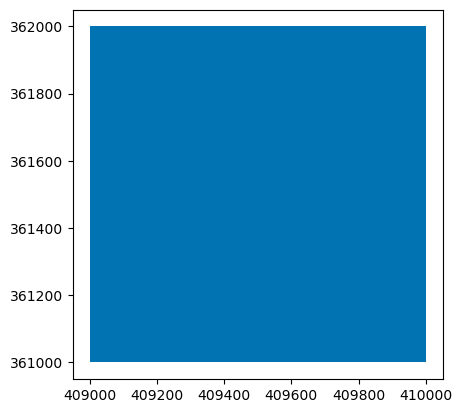

In [191]:
df_tiles_eval[df_tiles_eval['PLAN_NO'] == 'SK0961'].plot()

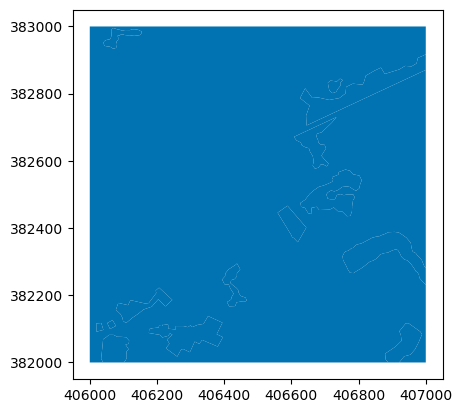

In [196]:
dict_dict_intersect_eval['22']['SK0682'].plot()

['Wood and Forest Land', 'Moor and Heath Land', 'Agro-Pastoral Land', 'Water and Wetland', 'Rock and Coastal Land', 'Developed Land', 'Unclassified Land']
80s 49957868.73755686
22 50000602.540111504
0.042733802554641556


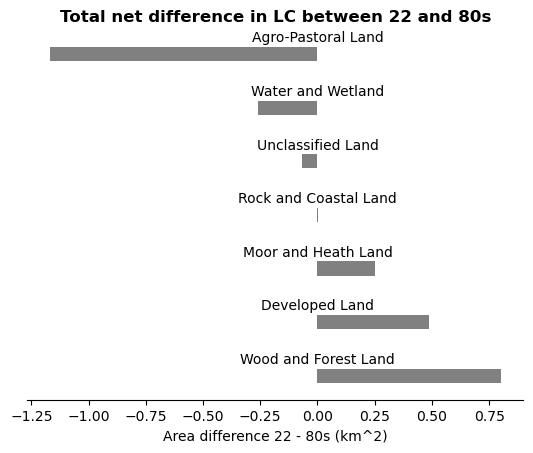

In [145]:
tmp = lcv.plot_difference_total_lc_from_dfs(dict_dfs=dict_df_eval_tiles_lc)

In [109]:
dict_df_eval_tiles_lc['22'] = dict_df_eval_tiles_lc['22'].iloc[np.where(dict_df_eval_tiles_lc['22']['Class name'] == '')[0]].assign(Class_Code='I')

In [140]:
dict_df_eval_tiles_lc['22']

,geometry,Class_Code,area,Class name
0,"POLYGON ((405000.003 403999.995, 405999.997 40...",D,9.999877e+05,Moor and Heath Land
1,"POLYGON ((406999.999 404999.999, 406999.999 40...",D,1.000006e+06,Moor and Heath Land
2,"POLYGON ((409000.004 400238.118, 408962.818 40...",I,8.873818e+05,Unclassified Land
3,"POLYGON ((408936.044 400000.000, 408937.694 40...",C,2.264764e+03,Wood and Forest Land
4,"POLYGON ((408684.824 400000.000, 408684.522 40...",E,1.092942e+05,Agro-Pastoral Land
...,...,...,...,...
370,"POLYGON ((424328.731 396999.999, 424328.142 39...",E,2.051922e+04,Agro-Pastoral Land
371,"POLYGON ((424364.416 395999.995, 424357.222 39...",E,3.344872e+05,Agro-Pastoral Land
372,"POLYGON ((424139.248 396228.554, 424138.529 39...",C,4.321682e+05,Wood and Forest Land
373,"POLYGON ((424115.392 396237.780, 424181.401 39...",D,5.338676e+04,Moor and Heath Land


# TODO
- Take intersection of pols and PD outline. Then leave No CLass/unclassified as a label 
- Total net gain/loss per LC (horizontal bar plot; sum pol areas)
- Gain & loss per pair of LCs. (Confusion matrix; loop through old pols and find intersection with new & add to count of new area)
